### Simulation of cell-by-gene count matrix
Here, we generate a cell-by-gene count matrix of order (#cells, #genes) for some given parameters. 

In [1]:
#call necessary libraries
import numpy as np
import igraph as ig
from functionsV2 import * 
import os
import matplotlib.pyplot as plt

In [2]:
PATH = os.path.expanduser('~') + '/Dropbox/suvranil/cellmem'

#### Parameters

We write all necessary parameters for simulation.

In [3]:
#gene network
ng = int(1024)    # number of genes in gene network
alpha = 2.0       # alpha is shape parameter of Gamma distribution
beta = 2.0        # bete is inverse scale parameter of Gamma dribution
muall = np.loadtxt(PATH +'/data' + '/gene_16384.txt')
mu = muall[: ng]
print('Mean of Mus: ', np.round(-np.mean(mu), 2))


#gene dynamics in root cell
t_s = 1000.0    # total time to find a stationary state
dt_s = 0.01     # time-step size
steps = int(np.round(t_s / dt_s))
amp = 0.1       # noise amplitude

#parameters for cell lineage 
trial = 2       # number of sample data matrices
tc = 0.5        # cell division time
p =  2          # step size = 10**-p
b = 12          # number of branch
nc = 2**(b - 1)
#comment : If we run code for b = 8, 
#...we will get max 2**7 cell in the final branch. 

Mean of Mus:  1.03


#### Simulation of cell lineage
First, we make sure every cells reach to stationary state. Then cells start dividing.

In [4]:
data_mat_list = []
for k in range(trial): 
    #initialization of root cell
    g_root = ig.Graph()
    g_root.add_vertices(int(1))
    g_root.vs[0]['gene'] = []
    gene_array = np.random.random(ng) # initial state of genes in the root cell

    #comment: to make sure all gene expressions x(t) > 0
    con_arr = np.ones(ng, dtype = np.float32)
    
    #steady state gene dynamics
    for i in range (0, steps, 1):
        # Euler-Maruyama method
        du = mu * gene_array * dt_s + con_arr * dt_s + amp * (dt_s**0.5) * np.random.normal(0.0,1.0, ng)
        gene_array += du
        g_root.vs[0]['gene'].append(np.copy(gene_array))


    #gene expression dynamis has reached near to steady state.
    root = np.copy(g_root.vs[0]['gene'][-1])
    #cell division starts.
    graph = cell_lineage_model(ng, amp, mu, b, root, tc, p)

    #taking snapshot
    snap = len(graph.vs[0]['time'])
    rows = 2**(b - 1)
    cols = ng
    add = 2**(b - 1) - 1    # add numbers to get 'right' cells
    #single snapshot data matrix (unprocessed / non-updated)
    data_mat = np.zeros((rows, cols), dtype = np.float32)
    for i in range (0, rows, 1):
        data_mat[i][0: ] = graph.vs[i + add]['gene'][snap - 2][0: ]
    data_mat_list.append(data_mat)
    print(k) #keeping track of trials
    del  graph, g_root

0
1


In [5]:
data = np.array(data_mat_list) #data matrices
print('Shape of ensemble of data mat: ', data.shape)

Shape of ensemble of data mat:  (2, 2048, 1024)


#### Store cell-by-gene data matrix

In [6]:
# np.save(PATH 
#         + '/data/20241212/'
#         + 'gene_{}_cell_{}_divtime_{}_amp_{}_trial_{}.npy'
#         .format(ng, nc, tc, amp, trial), data, allow_pickle = True)

We have got our sample data matrices. <br>
Let's check eigenspectra of cell covariance matrix once. 

#### Eigenspectra of cell covariance matrix

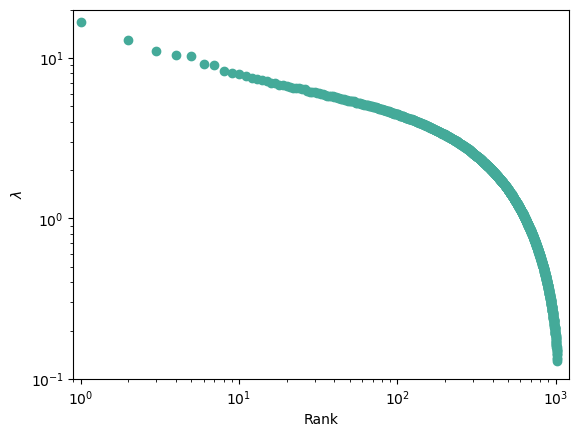

In [7]:
#single timepoint scRNA-seq data matrix
z = data[0]
#updated data matrix
X_S = (z - np.mean(z, axis = 0))/ np.std(z, axis = 0)
cv = np.matmul(X_S, X_S.T) / ng
ev = np.linalg.eigvalsh(cv)[::-1]
rank = np.linspace(1, nc, nc)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1, 20)
plt.xlim(0.9, ng + 200)
plt.xlabel('Rank')
plt.ylabel('$\lambda$')
plt.scatter(rank, ev, color = '#44aa99')

Cheers!